# Problem 3 - Answers

**Hypothesis testing**

#### Setup

In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import fmin
from scipy.stats import chisquare, norm
from tqdm.notebook import tqdm, trange

# Homogenise matplotlib plotting.
mpl.rc("axes", grid=True)
mpl.rc("grid", linestyle="--", alpha=0.4)
mpl.rc("legend", loc="best")

### Generate random samples and compare the expected and observed distributions

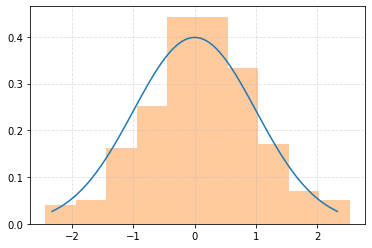

In [2]:
# Fix the parameters of the pdf. In this case, fix to the default or mean=0, std=1.
distr = norm(loc=0, scale=1)

# Use the percent point function (PPF) in order to determine limits.
xs = np.linspace(distr.ppf(0.01), distr.ppf(0.99), 100)
# Determine the value of the pdf between these limits.
fs = distr.pdf(xs)
plt.plot(xs, fs, zorder=5)

# Ensure the runs are repeatable.
rng = np.random.RandomState(1)

# Sample from the pdf randomly and bin the results.
_ = plt.hist(distr.rvs(200, random_state=rng), density=True, alpha=0.4)

### Chi-square test - Type I Errors

In the context of the above example, the null hypothesis $H_0$ is that the samples originate from a normal distribution with parameters $\mu=0$ and $\sigma=1$.

Type I Error are 'false positives', meaning that $H_0$ is rejected while it is true.
Here this would imply rejecting the notion that the samples originate from the aforementioned normal distribution, even though (we know) that they are.

This example explicitly simulates the rate of occurrence of Type I errors.
The bins are defined according to equal probability.
Note that without an explicit alternative hypothesis, Type II errors cannot be quantified.

,Observed Type I Error
Significance Level,
0.10,0.12
0.05,0.05
0.01,0.00


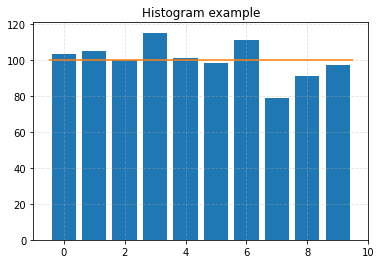

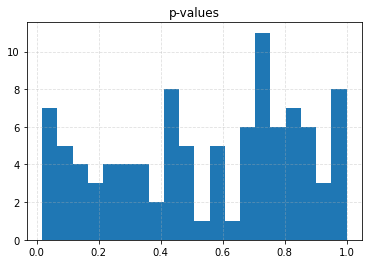

In [3]:
# The number of bins. The number of bin edges will exceed this by 1.
n_bins = 10
# Number of samples. This has to be high enough to ensure a sufficient number
# of samples per bin, given the number of bins above.
n_samples = 1000

# Fix the parameters of the pdf. In this case, fix to the default or mean=0, std=1.
distr = norm(loc=0, scale=1)

# Use the percent point function (PPF) in order to determine the bin edges
# such that the bins contain equal probabilities. The upper and lower bin edges
# will be 'inf' and '-inf', which the numpy histogram function can handle.
bin_edges = distr.ppf(np.linspace(0, 1, n_bins + 1))

# Calculate the expected number of samples per bin.
expected = (1 / n_bins) * n_samples

assert expected > 20, "Need more than 20 samples per bin for chi-square."

# The number of runs.
trials = 100

# Store test p-values.
p_values = np.empty(trials)

for i in trange(trials):
    # Generate random variates using different (but still repeatable) seeds.
    samples = distr.rvs(n_samples, random_state=np.random.RandomState(i))

    binned = np.histogram(samples, bins=bin_edges)[0]

    # Compute the chi-squared test statistic and p-value.
    chisq, p = chisquare(f_obs=binned, f_exp=expected, ddof=0)
    p_values[i] = p

    if i == 0:
        # Visualise a subset.
        plt.figure()
        plt.bar(np.arange(len(binned)), binned)
        plt.title("Histogram example")
        plt.hlines(expected, -0.5, len(binned) - 0.5, color="C1")

plt.figure()
plt.title("p-values")
plt.hist(p_values, bins=20)

# Determine the actual type I errors for different significance levels.

df = pd.Series(
    {alpha: np.sum(p_values < alpha) / trials for alpha in [0.1, 0.05, 0.01]}
).to_frame()
df.columns = ["Observed Type I Error"]
df.index.name = "Significance Level"
df

### Numerical maximum likelihood parameter estimation

Since analytical solutions are not possible for every pdf, numerical maximisation of the likelihood function may be necessary in order to estimate parameters.
Here, you will design a simple numerical solution for the normal distribution, maximising the log-likelihood.

#### Write a function that calculates the log-likelihood for the normal distribution

This can return the log-likelihood up to a constant, if you wish.
For 1000 samples from a normal distribution with $\mu=0$ and $\sigma=1$ (with a fixed seed), visualise the 2D surface of the log-likelihood function using a contour plot.

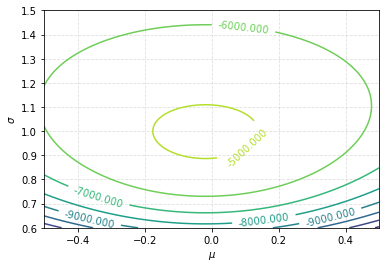

In [4]:
def log_likelihood(mu, sigma, obs):
    """Log-likelihood function for a normal distribution.
    
    Parameters
    ----------
    mu : float
        Mean.
    sigma : float
        Standard deviation.
    obs : array-like
        Obsevations.
        
    Returns:
        The value of the log-likelihood for (`mu`, `sigma`), given the
        observations, up to a constant.
    
    """
    obs = np.asarray(obs)
    N = obs.shape[0]
    return -N * np.log(sigma) - (1 / (2 * sigma ** 2)) * np.sum((obs - mu) ** 2)


# Number of samples.
n_samples = 10000

# Fix the parameters of the pdf. In this case, fix to the default or mean=0, std=1.
distr = norm(loc=0, scale=1)

# Generate random variates using a seed.
samples = distr.rvs(n_samples, random_state=np.random.RandomState(0))

# Generate the grid on which to calculate the log-likelihood values.
N = 100
mus = np.linspace(-0.5, 0.5, N)
sigmas = np.linspace(0.6, 1.5, N)
values = np.empty((N, N))
for i, mu in enumerate(tqdm(mus)):
    for j, sigma in enumerate(sigmas):
        values[i, j] = log_likelihood(mu, sigma, samples)

plt.figure()
CS = plt.contour(mus, sigmas, values.T)
plt.clabel(CS)
plt.xlabel(r"$\mu$")
_ = plt.ylabel(r"$\sigma$")

#### Optimise the above function using `scipy.optimize.fmin`

Note that we want to _maximise_ the log-likelihood, but `fmin` wants to minimise the function.
It also accepts the parameters ($\mu, \sigma$) as a 'vector' of arguments, and not as separate arguments as above.

In [5]:
# Number of samples.
n_samples = 100

# Fix the parameters of the pdf. In this case, fix to the default or mean=0, std=1.
distr = norm(loc=0, scale=1)

# Generate random variates using a seed.
samples = distr.rvs(n_samples, random_state=np.random.RandomState(0))

xopt = fmin(
    lambda x, obs: -log_likelihood(*x, obs), [0, 1], args=(samples,), disp=False
)
print(f"mu: {xopt[0]:0.2f}, sigma: {xopt[1]:0.2f}")

mu: 0.06, sigma: 1.01


### Maximum likelihood estimation and chi-square test

The chi-squared test will be used to determine if generated samples originate from a normal distribution.

Prior to the test, parameters will be estimated numerically using the maximum likelihood optimisation procedure, as above.
The estimated parameters will then be used to compute the expected bin counts.

The number of degrees of freedom is varied too, since we are now estimating parameters! 

ddof,0,1,2,3
Significance Level,,,,
0.10,0.0426,0.0708,0.1056,0.1626
0.05,0.0204,0.0334,0.0536,0.0880
0.01,0.0030,0.0056,0.0096,0.0206


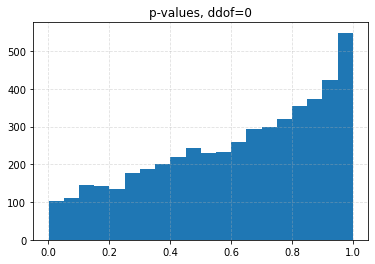

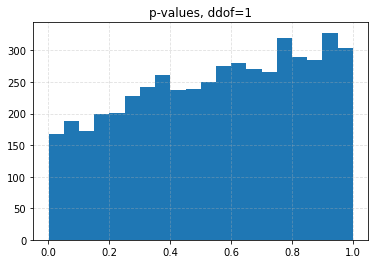

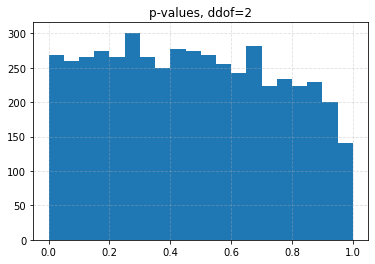

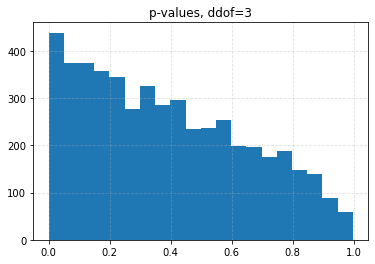

In [6]:
# The number of bins. The number of bin edges will exceed this by 1.
n_bins = 10
# Number of samples. This has to be high enough to ensure a sufficient number
# of samples per bin, given the number of bins above.
n_samples = 10000

# Fix the parameters of the pdf. In this case, fix to the default or mean=0, std=1.
distr = norm(loc=0, scale=1)

# Calculate the expected number of samples per bin.
expected = (1 / n_bins) * n_samples

assert expected > 20, "Need more than 20 samples per bin for chi-square."

# The number of runs.
trials = 5000

# Store test p-values.
p_values = np.empty(trials)
sig_data = {}

for ddof in tqdm([0, 1, 2, 3], desc="Varying degrees of freedom", smoothing=0):
    for i in range(trials):
        # Generate random variates using different (but still repeatable) seeds.
        samples = distr.rvs(n_samples, random_state=np.random.RandomState(i))

        # Estimate the parameters using the maximum likelihood.
        xopt = fmin(
            lambda x, obs: -log_likelihood(*x, obs), [0, 1], args=(samples,), disp=False
        )

        # Use the percent point function (PPF) in order to determine the bin edges
        # such that the bins contain equal probabilities. The upper and lower bin edges
        # will be 'inf' and '-inf', which the numpy histogram function can handle.
        bin_edges = norm(loc=xopt[0], scale=xopt[1]).ppf(np.linspace(0, 1, n_bins + 1))
        # Bin the generated data using the new samples.
        binned = np.histogram(samples, bins=bin_edges)[0]

        # Compute the chi-squared test statistic and p-value.
        chisq, p = chisquare(f_obs=binned, f_exp=expected, ddof=ddof)
        p_values[i] = p

    plt.figure()
    plt.title(f"p-values, ddof={ddof}")
    plt.hist(p_values, bins=20)

    # Determine the actual type I errors for different significance levels.
    sig_data[ddof] = {
        alpha: np.sum(p_values < alpha) / trials for alpha in [0.1, 0.05, 0.01]
    }

df = pd.DataFrame(sig_data)
df.columns.name = "ddof"
df.index.name = "Significance Level"
df

### Minimum chi-squared estimation and chi-square test

The chi-squared test will be used to determine if generated samples originate from a normal distribution.

Prior to the test, parameters will be estimated numerically using the minimum chi-square optimisation procedure.
The estimated parameters will then be used to compute the expected bin counts.

The number of degrees of freedom is varied too, since we are now estimating parameters! 

ddof,0,1,2,3
Significance Level,,,,
0.10,0.041,0.0662,0.1016,0.1554
0.05,0.020,0.0308,0.0510,0.0858
0.01,0.003,0.0062,0.0108,0.0208


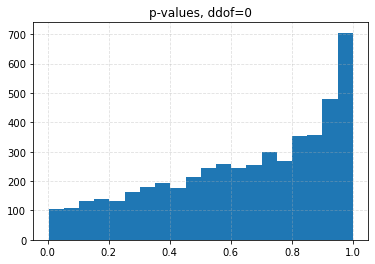

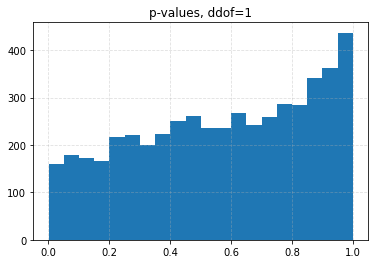

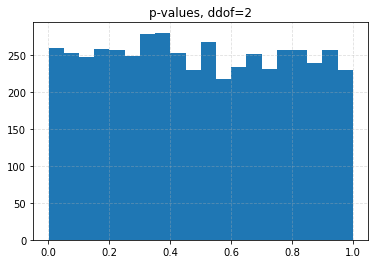

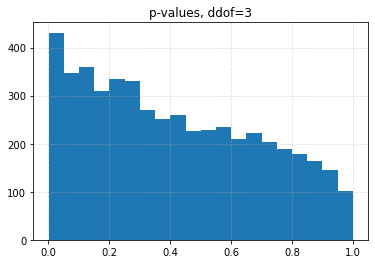

In [7]:
def get_expected_density(mu, sigma, bin_edges):
    """Calculate the expected proportion of samples.
    
    Parameters
    ----------
    mu : float
        Mean of the normal distribution.
    sigma : float
        Standard deviation of the normal distribution.
    bin_edges : array-like
        Bin edges.
    
    """
    # Allow other array-like containers to be used.
    bin_edges = np.asarray(bin_edges)

    distr = norm(loc=mu, scale=sigma)
    # Given the distribution, compute the expected counts in each bin using
    # the cumulative density function.
    return np.diff(distr.cdf(bin_edges))


def chisquare_value(x, bin_edges, obs_counts):
    """Calculate the chi square values for given normal distribution parameters.
    
    Parameters
    ----------
    x : array-like
        Mean and standard deviation of the normal distribution.
    bin_edges : array-like
        Bin edges.
    obs_counts : array-like
        Observed counts in the bins given by `bin_edges`.
    
    Returns
    -------
    chi_square : float
        chi-square value.
    
    """
    # Allow other array-like containers to be used.
    bin_edges = np.asarray(bin_edges)

    expected = get_expected_density(*x, bin_edges)

    # Normalise the observed counts in order to match the above.
    norm_obs_counts = obs_counts / np.sum(obs_counts)
    return chisquare(f_obs=norm_obs_counts, f_exp=expected)[0]


# The number of bins. The number of bin edges will exceed this by 1.
n_bins = 10
# Number of samples. This has to be high enough to ensure a sufficient number
# of samples per bin, given the number of bins above.
n_samples = 1000

# Fix the parameters of the pdf. In this case, fix to the default or mean=0, std=1.
distr = norm(loc=0, scale=1)

# Calculate the expected number of samples per bin.
expected = (1 / n_bins) * n_samples

assert expected > 20, "Need more than 20 samples per bin for chi-square."

# The number of runs.
trials = 5000

# Store test p-values.
p_values = np.empty(trials)
sig_data = {}


for ddof in tqdm([0, 1, 2, 3], desc="Varying degrees of freedom", smoothing=0):
    for i in range(trials):
        # Generate random variates using different (but still repeatable) seeds.
        samples = distr.rvs(n_samples, random_state=np.random.RandomState(i))

        # Use binning in order to create the bin edges.
        bin_edges = np.quantile(samples, np.linspace(0, 1, n_bins + 1))
        # Bin the generated data using the new samples.
        binned = np.histogram(samples, bins=bin_edges)[0]

        # Estimate the parameters using the minimum chi-square method,
        # varying the parameters until the expected counts in the above bins
        # best match the observed counts.
        xopt = fmin(chisquare_value, [0, 1], args=(bin_edges, binned), disp=False)

        binned_expected = get_expected_density(*xopt, bin_edges) * n_samples

        # Compute the chi-squared test statistic and p-value.
        chisq, p = chisquare(f_obs=binned, f_exp=binned_expected, ddof=ddof)
        p_values[i] = p

    plt.figure()
    plt.title(f"p-values, ddof={ddof}")
    plt.hist(p_values, bins=20)

    # Determine the actual type I errors for different significance levels.
    sig_data[ddof] = {
        alpha: np.sum(p_values < alpha) / trials for alpha in [0.1, 0.05, 0.01]
    }

df = pd.DataFrame(sig_data)
df.columns.name = "ddof"
df.index.name = "Significance Level"
df